Importing the necessaries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.ensemble import IsolationForest
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
import torch
import xgboost as xgb

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the dataset from disk

In [2]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Inspecting data

In [3]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,daca se bate cu o fata,1,0,0,0,0
1,am eu,1,0,0,0,0
2,Ba sterfe mesaju,1,0,0,0,0
3,romania,1,0,0,0,0
4,intrati,1,0,0,0,0


In [4]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,cum se traduce numele tau an romana,1,0,0,0,0
1,zi conturile de trb sa intru,1,0,0,0,0
2,se gandeste la mine zilnic 3,1,0,0,0,0
3,pls,1,0,0,0,0
4,sa ma pis,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [5]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,9951.000000,9951.000000,9951.000000,9951.000000,9951.000000
mean,0.535022,0.429304,0.016782,0.134760,0.051452
std,0.498797,0.495002,0.128461,0.341485,0.220929
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,0.535398,0.429606,0.012872,0.142800,0.050282
std,0.498846,0.495119,0.112745,0.349939,0.218569
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   9951 non-null   object
 1   OK        9951 non-null   int64 
 2   Aggro     9951 non-null   int64 
 3   Violence  9951 non-null   int64 
 4   Sexual    9951 non-null   int64 
 5   Hateful   9951 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 466.6+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   2486 non-null   object
 1   OK        2486 non-null   int64 
 2   Aggro     2486 non-null   int64 
 3   Violence  2486 non-null   int64 
 4   Sexual    2486 non-null   int64 
 5   Hateful   2486 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 116.7+ KB


In [9]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [10]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (9951, 6)
Test shape:  (2486, 6)


In [11]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 141
Number of duplicated instances in test: 10


In [12]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.930356 -0.140142 -0.423333 -0.249828
Aggro    -0.930356  1.000000  0.038416  0.327191  0.192252
Violence -0.140142  0.038416  1.000000  0.026336  0.036855
Sexual   -0.423333  0.327191  0.026336  1.000000  0.146540
Hateful  -0.249828  0.192252  0.036855  0.146540  1.000000


Data visualization

In [13]:
import matplotlib.pyplot as plt # importing the neccessary library

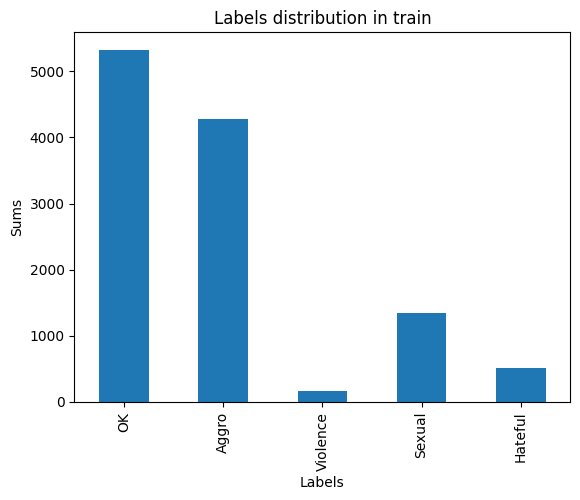

OK          5324
Aggro       4272
Violence     167
Sexual      1341
Hateful      512
dtype: int64


In [14]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

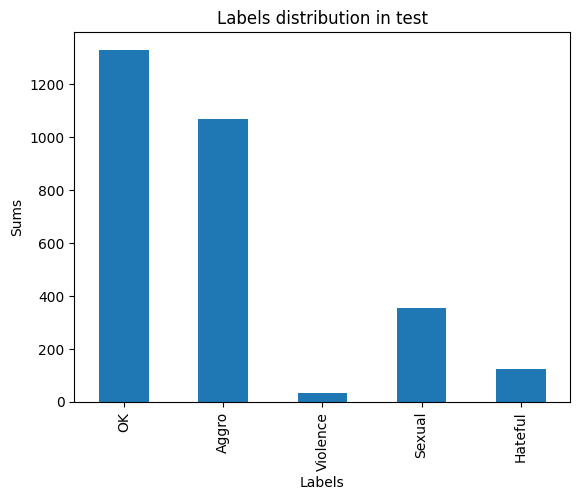

OK          1331
Aggro       1068
Violence      32
Sexual       355
Hateful      125
dtype: int64


In [15]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

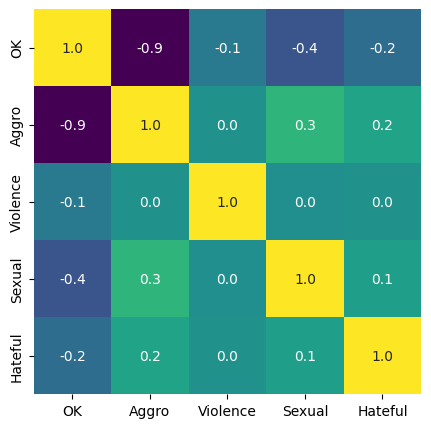

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

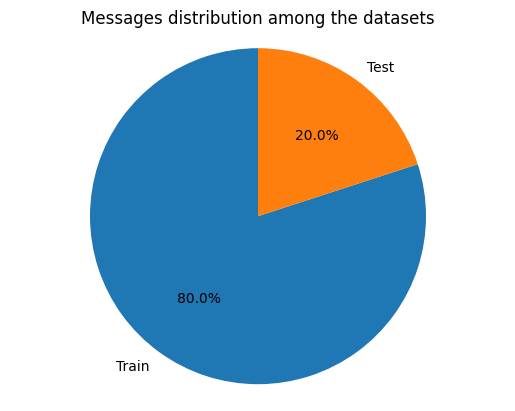

[9951, 2486]


In [17]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [18]:
accuracy_array = []
models_used = ['v1-small', 'v1-base', 'v1-s-fold']

### My model

In [19]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [20]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        softmax = torch.nn.Softmax()
        probs = softmax(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.argmax(probs)] = 1
        return predictions

In [21]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v1-small', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [22]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/v1-small/')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

In [23]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [24]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [25]:
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.8299643287911149
Precision: 0.9244155408534976
Recall: 0.809000343524562
Accuracy: 0.8012872083668544
ROC AUC: 0.721288272332248


In [26]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[1085,   70],
        [  42, 1289]],

       [[1376,   42],
        [  85,  983]],

       [[2451,    3],
        [  27,    5]],

       [[2123,    8],
        [ 286,   69]],

       [[2353,    8],
        [ 116,    9]]], dtype=int64)

In [27]:
toxicityModel = ToxicityModel(
    model_name='./model_versions/v1-base', # 4 epochs 8 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [28]:
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.8326065234375434
Precision: 0.9173620480852444
Recall: 0.8031604259704569
Accuracy: 0.7948511665325825
ROC AUC: 0.7367784815070442


In [29]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[1079,   76],
        [  54, 1277]],

       [[1382,   36],
        [ 114,  954]],

       [[2448,    6],
        [  24,    8]],

       [[2115,   16],
        [ 274,   81]],

       [[2347,   14],
        [ 107,   18]]], dtype=int64)

In [30]:
toxicityModel = ToxicityModel(
    model_name='./model_versions/v1-small-fold-5', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [31]:
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.8509664021462882
Precision: 0.9633962616691988
Recall: 0.8330470628649949
Accuracy: 0.82864038616251
ROC AUC: 0.7345501771150262


In [32]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[1123,   32],
        [  11, 1320]],

       [[1396,   22],
        [  39, 1029]],

       [[2454,    0],
        [  26,    6]],

       [[2130,    1],
        [ 295,   60]],

       [[2355,    6],
        [ 115,   10]]], dtype=int64)

### Setting Xs and ys

In [33]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(9951, 24796)


In [34]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(2486, 24796)

### Isolation Forest

In [35]:
clf =  IsolationForest(n_estimators=50, max_samples="auto", random_state=42, contamination=float(0.1))

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

clf.fit(X_train_2d)

IsolationForest(contamination=0.1, n_estimators=50, random_state=42)

In [36]:
df_train['scores'] = clf.decision_function(X_train_2d)
df_train['anomaly'] = clf.predict(X_train_2d)

df_train.head(20)

,Message,OK,Aggro,Violence,Sexual,Hateful,scores,anomaly
0,daca se bate cu o fata,1,0,0,0,0,0.136932,1
1,am eu,1,0,0,0,0,-0.166721,-1
2,Ba sterfe mesaju,1,0,0,0,0,0.174070,1
3,romania,1,0,0,0,0,0.143862,1
4,intrati,1,0,0,0,0,0.181752,1
5,waileu ce ploua,1,0,0,0,0,0.113567,1
6,efa,1,0,0,0,0,0.186825,1
7,no problem,1,0,0,0,0,0.143310,1
8,cel mai bun ADC are un positioning nu ajung nm...,1,0,0,0,0,0.068789,1
9,lol,1,0,0,0,0,0.116664,1


In [37]:
anomaly = df_train.loc[df_train['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

                                                Message  OK  Aggro  Violence  \
1                                                 am eu   1      0         0   
14                                                Da eu   1      0         0   
24                                                 n am   1      0         0   
40                                         eu confundam   1      0         0   
49    de asta am si inceput sa scriu pe all chat can...   1      0         0   
...                                                 ...  ..    ...       ...   
9806        Nu am mai vazut pizda de cand eram cu fosta   0      0         0   
9824                                        te fut i eu   0      0         0   
9841                          la ce voce de pizda aveai   0      0         0   
9848                   le bag muie la jucatori de viego   0      0         0   
9870                              eu ti o sug daca vrei   0      0         0   

      Sexual  Hateful    scores  anomal

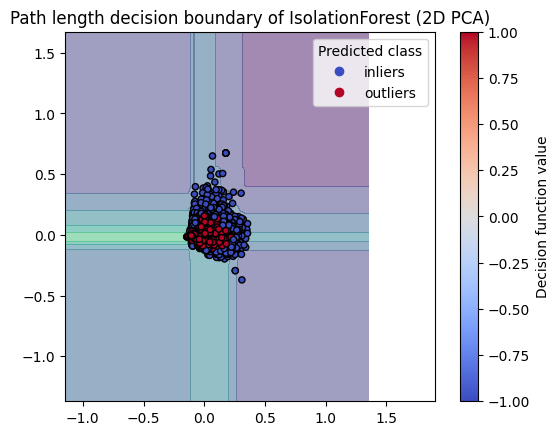

In [38]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_2d,
    response_method="decision_function",
    alpha=0.5,
)

y_pred = clf.predict(X_train_2d)  # -1 for outliers, 1 for inliers
scatter = disp.ax_.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")

disp.ax_.set_title("Path length decision boundary of IsolationForest (2D PCA)")
plt.axis("square")

# Legend for predicted classes
plt.legend(handles=scatter.legend_elements()[0], labels=["inliers", "outliers"], title="Predicted class")

# Add a color bar for the decision boundary
plt.colorbar(disp.ax_.collections[1], ax=disp.ax_, label="Decision function value")

plt.show()

df_train.drop(columns=['scores', 'anomaly'], inplace=True)

### Other algorithms

In [39]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
multi_target_model = MultiOutputClassifier(xgb_model)
multi_target_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [40]:
y_pred = multi_target_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('XGBClassifier')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1331
           1       0.93      0.82      0.87      1068
           2       0.70      0.22      0.33        32
           3       0.84      0.45      0.59       355
           4       0.91      0.48      0.63       125

   micro avg       0.88      0.82      0.85      2911
   macro avg       0.85      0.59      0.66      2911
weighted avg       0.88      0.82      0.83      2911
 samples avg       0.87      0.85      0.85      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

model.fit(X_train.toarray(), y_train)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         random_state=42)

In [42]:
y_pred = model.predict(X_test.toarray())
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_array.append(accuracy)
models_used.append('GPR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1331
           1       0.90      0.80      0.85      1068
           2       0.59      0.41      0.48        32
           3       0.59      0.45      0.51       355
           4       0.74      0.42      0.53       125

   micro avg       0.83      0.79      0.81      2911
   macro avg       0.73      0.60      0.65      2911
weighted avg       0.83      0.79      0.80      2911
 samples avg       0.84      0.83      0.82      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [44]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('R.Forest')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1331
           1       0.80      0.82      0.81      1068
           2       1.00      0.22      0.36        32
           3       0.32      0.24      0.27       355
           4       0.89      0.19      0.32       125

   micro avg       0.78      0.72      0.75      2911
   macro avg       0.77      0.46      0.52      2911
weighted avg       0.78      0.72      0.74      2911
 samples avg       0.81      0.76      0.77      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
model = MultiOutputClassifier(GaussianNB())
model.fit(X_train.toarray(), y_train)

MultiOutputClassifier(estimator=GaussianNB())

In [46]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('GaussianNB')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.42
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1331
           1       0.83      0.88      0.86      1068
           2       0.05      0.50      0.09        32
           3       0.15      0.45      0.22       355
           4       0.04      0.21      0.06       125

   micro avg       0.51      0.78      0.62      2911
   macro avg       0.39      0.58      0.42      2911
weighted avg       0.73      0.78      0.74      2911
 samples avg       0.65      0.82      0.67      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier())

In [48]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('DT')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1331
           1       0.70      0.80      0.74      1068
           2       0.50      0.41      0.45        32
           3       0.37      0.55      0.44       355
           4       0.78      0.74      0.76       125

   micro avg       0.68      0.73      0.71      2911
   macro avg       0.63      0.64      0.63      2911
weighted avg       0.71      0.73      0.71      2911
 samples avg       0.71      0.73      0.71      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [50]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('LR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1331
           1       0.90      0.86      0.88      1068
           2       0.00      0.00      0.00        32
           3       0.80      0.24      0.37       355
           4       1.00      0.02      0.05       125

   micro avg       0.88      0.76      0.82      2911
   macro avg       0.72      0.41      0.44      2911
weighted avg       0.87      0.76      0.78      2911
 samples avg       0.86      0.81      0.83      2911



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparing accuracy between algorithms

<BarContainer object of 9 artists>

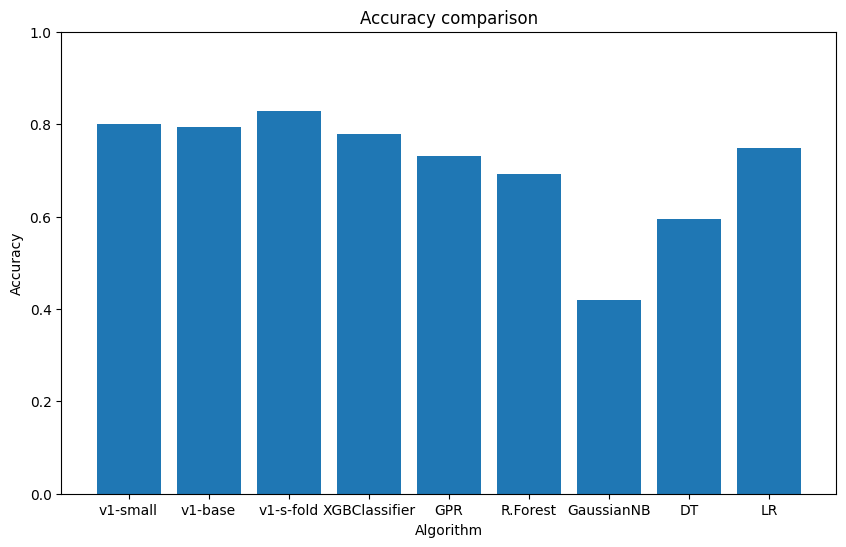

In [51]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, accuracy_array)